In [1]:
"""
LSTM model to predict network traffic.
Current traffic data is retrived from live Ericsson's MME.

The data is stored in csv format and each column is seperated by comma
date      ,time    ,counter
2017.03.26,03:00:03,47083475
2017.03.26,04:00:03,46852978
2017.03.26,05:00:03,48001319
...

"""

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf

plt.rcParams['figure.figsize'] = (8.0, 8.0) # set default size of plots

In [2]:
dataFile        = "./CMCC_hnzz_ETH1_25_inbound_data/201703250700201703312300.csv" 

# init param
seq_size          = 24      # always use last past 24 hours' data to predict next hour
train_data_size   = 24 * 3  # 72 hours' data for training
prediction_size   = 68      # predict next 68 hours' traffic
input_dim         = 1       # input dimension
hidden_layer_size = 16      # hidden layer size

# save model file name
saveModeFile    = "./pred_" + "s" + str(seq_size) + "t" + str(train_data_size) + ".model" # save trained model

In [3]:
def ass_rnn(hidden_layer_size=6):
    # random initialize is not good, sometimes model could not converge
    W = tf.Variable(tf.random_normal([hidden_layer_size, 1]), name='W')
    b = tf.Variable(tf.random_normal([1]), name='b')
    cell = tf.contrib.rnn.BasicLSTMCell(hidden_layer_size)
    (outputs, states) = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
    W_repeated = tf.tile(tf.expand_dims(W, 0), [tf.shape(X)[0], 1, 1])
    out = tf.matmul(outputs, W_repeated) + b
    out = tf.squeeze(out)
    return out

In [4]:
def train_rnn(train_x, train_y):        

    loss = tf.reduce_mean(tf.square(out - Y))
    train_op = tf.train.AdamOptimizer(learning_rate=0.003).minimize(loss)

    saver = tf.train.Saver(tf.global_variables())
    with tf.Session() as sess:
        tf.get_variable_scope().reuse_variables()
        sess.run(tf.global_variables_initializer())

        for step in range(10001):
            _, loss_ = sess.run([train_op, loss], feed_dict={X: train_x, Y: train_y})

            if step % 1000 == 0:                
                print(step, loss_)
        print("save model: ", saver.save(sess, saveModeFile))

In [5]:
def prediction():
    saver = tf.train.Saver(tf.global_variables())
    with tf.Session() as sess:            
        saver.restore(sess, saveModeFile)
        
        prev_seq = train_x[-1]
        predict = []
        
        for i in range(prediction_size):
            next_seq = sess.run(out, feed_dict={X: [prev_seq]})
            predict.append(next_seq[-1])
            prev_seq = np.vstack((prev_seq[1:], next_seq[-1]))

    
    pred_indice = list(range(len(normalized_data) - 2 , max(len(normalized_data) + len(predict) - 2, len(normalized_data))) )   
    actual_val  = normalized_alldata[pred_indice]    
    MSE_pred    = (actual_val - predict) ** 2 / len(pred_indice)
    print("MSE of %d hours' prediction is %5f " % (prediction_size, np.sum(MSE_pred)))
    
    
    # visualization
    plt.figure()    
    ax = plt.gca()    
    
    ticks = [i * 16 for i in range(24)] # one tick every 16 hours
    ax.set_xticks(ticks)
    ax.set_xticklabels(df['time'][ticks])    
    ax.set_title("Prediction of trafic")
    plt.xlabel('Data-time')
    plt.ylabel('Counter')
        
    legend_act,  = plt.plot(list(range(len(normalized_alldata))), normalized_alldata * np.std(rawdata) + np.mean(rawdata), color='b')    
    legend_pred, = plt.plot(list(range(len(normalized_data) - 2 , len(normalized_data) + len(predict) - 2)), np.array(predict) * np.std(rawdata) + np.mean(rawdata), color='r')        
    plt.legend((legend_act,legend_pred,),("actual","prediction",))
    plt.show()


In [6]:
X = tf.placeholder(tf.float32, [None, seq_size, input_dim])
Y = tf.placeholder(tf.float32, [None, seq_size])

In [7]:
# normalize
df                 = pd.read_csv(dataFile)  
rawdata            = np.array(df['counter'])
normalized_alldata = (rawdata - np.mean(rawdata)) / np.std(rawdata)
normalized_data    = normalized_alldata[0:train_data_size] 

In [8]:
# prepare training data
train_x, train_y = [], []
for i in range(len(normalized_data) - seq_size - 1):
    train_x.append(np.expand_dims(normalized_data[i : i + seq_size], axis=1).tolist())
    train_y.append(normalized_data[i + 1 : i + seq_size + 1].tolist())

In [9]:
out = ass_rnn(hidden_layer_size)
train_rnn(train_x,train_y)

0 4.23403
1000 0.0184147
2000 0.0127838
3000 0.0110009
4000 0.00972542
5000 0.00892188
6000 0.00829149
7000 0.0077418
8000 0.00733041
9000 0.00706952
10000 0.00692143
save model:  ./pred_s24t72.model


INFO:tensorflow:Restoring parameters from ./pred_s24t72.model
MSE of 68 hours' prediction is 0.016983 


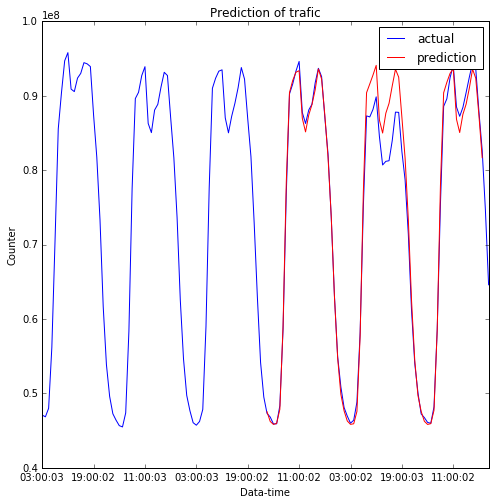

In [10]:
prediction()